# Identifying Pulsar Stars Using Integrated and DM-SNR Profiles #
#### Katie Liang and Madilyn Portas ####
***

### INTRODUCTION ###
Pulsar stars are a particular class of stars, under the category of neutron stars, that emit radio frequencies measurable on Earth. Since the radio frequency detected is dependent upon their rotation, their rotation creates a periodic radio signal, allowing for their identification as pulsars. Unfortunately, due to noise and radio frequency interference (RFI), most stars measured to have this periodicity are in fact not pulsars. 

Question:  
**Given the value for the mean of the integrated profile and the mean of the DM-SNR profile, is the frequency a pulsar star or not?**

We chose the predictive variables mean of the integrated profile and mean of the DM-SNR profile, as they are very representative and simple statistics of the data. The mean gives a strong idea of how the original data looked, whereas statistics such as the standard deviation, skewness, and excess kurtosis appear to be less helpful in this regard on their own. Essentially, if we were to use predictive variables such as excess kurtosis, they would be confusing and potentially less helpful overall without also using the mean. Thus, for the sake of clarity, precision, and simplicity, the two mean variables were chosen. 

This dataset includes 17898 potential pulsar candidates, described by 8 continuous variables, and finally their determined class. It does not have any missing values. 

Defining variables:   
A) Integrated profile: the intensity of the radio frequency signal, as a function of phase.   
B) DM-SNR curve: DM (dispersion measure) flattened in relation to the S/N ratio (signal to noise), such that the S/N ratio is maximized and greater than one at a DM greater than zero. That is to say, the signal for an actual pulsar should be greater than the noise, at a legitimate DM. 

Variables: 
1. ip_mean: mean of A).
2. ip_sd: standard deviation of A). 
3. ip_ek: excess kurtosis of A). 
4. ip_s: skewness of A). 
5. DM_mean: mean of B).
6. DM_sd: standard deviation of B). 
7. DM_ek: excess kurtosis of B). 
8. DM_s: skewness of B).
9. class: whether the candidate is a pulsar or not, where 0 is not a pulsar, and 1 is.

Useful definitions:   
Excess kurtosis: quantification of when there are many outliers, in excess of that expected of a normal distribution.   
Skewness: a measure of asymmetry.

***

### METHODS AND RESULTS ###

In [15]:
# 1 
# loading libraries
library(tidyverse)
library(tidymodels)
library(dplyr)
library(RColorBrewer)
install.packages('kknn')
library('kknn')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



1. Load required libraries
    + tidyverse 
        + made read_csv accessible
        + contains many functions to load, clean, wrangle, and visualize data
    + tidymodels
        + perform K-nearest neighbor classification in R
    + dplyr
        + to rename column
    + RColorBrewer
        + set the color of the visualizations to color friendly
    + ‘kknn’
        + to install manually in jupyter lab


In [2]:
# 2
# load data
url <- "https://raw.githubusercontent.com/madiportas/dsci-100_group_project/main/HTRU_2.csv"
pulsar_raw <- read.csv(url) |>
              rename(ip_mean = integrated_profile_mean,
                     ip_sd = integrated_profile_sd,
                     ip_ek = integrated_profile_ek,
                     ip_s = integrated_profile_s,
                     DM_mean = DM.SNR_curve_mean, 
                     DM_sd = DM.SNR_curve_sd, 
                     DM_ek = DM.SNR_curve_ek,
                     DM_s = DM.SNR_curve_s)

# wrangle data, remove uneeded columns
pulsar <- pulsar_raw |>
    mutate(class = as.factor(class), class = recode(class, "0" = "Not Pulsar", "1" = "Pulsar"))|>
    select(ip_mean, DM_mean, class)|>
    group_by(class) |>
    slice(1:500, tail(500))

# split data 
set.seed(1)
pulsar_split <- initial_split(pulsar, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

2. Load, clean and wrangle data. 
    + Load the dataset from Lyon, R. J. (n.d.). HTRU2. UC Irvine Machine Learning Repository. Since the dataset is already in a csv file, we do not need to do any extra work to connect the dataset with R. Therefore, we can simply load our dataset by using read_csv. 
    + Preview the dataset and check for variable names and ?
    + Rename the variable into a simpler version
    + Mutate class into a factor because that is what we want to predict
    + Select the predictors and remove the ? in each selected variables
    + Group by class, and slice the start and end of the data set 
    + We decided to select 1000 data points, as the data set was very large and likely would take too long to run when training and testing. Importantly, to prevent an imbalance due to the heavy prevalence of non-pulsar data points, we selected 500 of each class for the training and testing. This will prevent the non-pulsar predictions from predominating, and incorrectly inflating the accuracy of our model. 
    + Split the dataset into training data and testing data, so that we can use K-nearest neighbors to predict our result


In [3]:
# 3 
# summarize data as part of preliminary data analysis
summary <- group_by(pulsar_train, class) |>
    summarize(
        mean_ip = mean(ip_mean),
        max_ip = max(ip_mean), 
        min_ip = min(ip_mean), 
        mean_DM = mean(DM_mean),
        max_DM = max(DM_mean), 
        min_DM = min(DM_mean))
print("Table 1. Summary of Training Data")
summary

[1] "Table 1. Summary of Training Data"


class,mean_ip,max_ip,min_ip,mean_DM,max_DM,min_DM
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Not Pulsar,117.3935,169.5391,65.07031,5.64903,211.9490,0.5359532
Pulsar,62.8469,130.3438,6.93750,38.89381,178.7007,0.8645485


> This table summarizes the mean, maximum, and minimum values of our predictive variables in our training data. The means in particular seem noticeably different, which supports our choice of predictive variables. 


3. Perform a summary table
    + Group the variable class into two observations: Pulsar and not Pulsar
    + Summarize the mean, max, and min of each predictor chosen 
    + The mean, max, and min, are particularly useful as they provide a quantitative check that the two classes are different, there are apparent differences in these quantities, supporting our use of these particular predictive variables for KNN. This summary table also gives a quick check that there are no major issues with our previous steps; the cleaning and wrangling was successful, without looking at the entire dataset. 


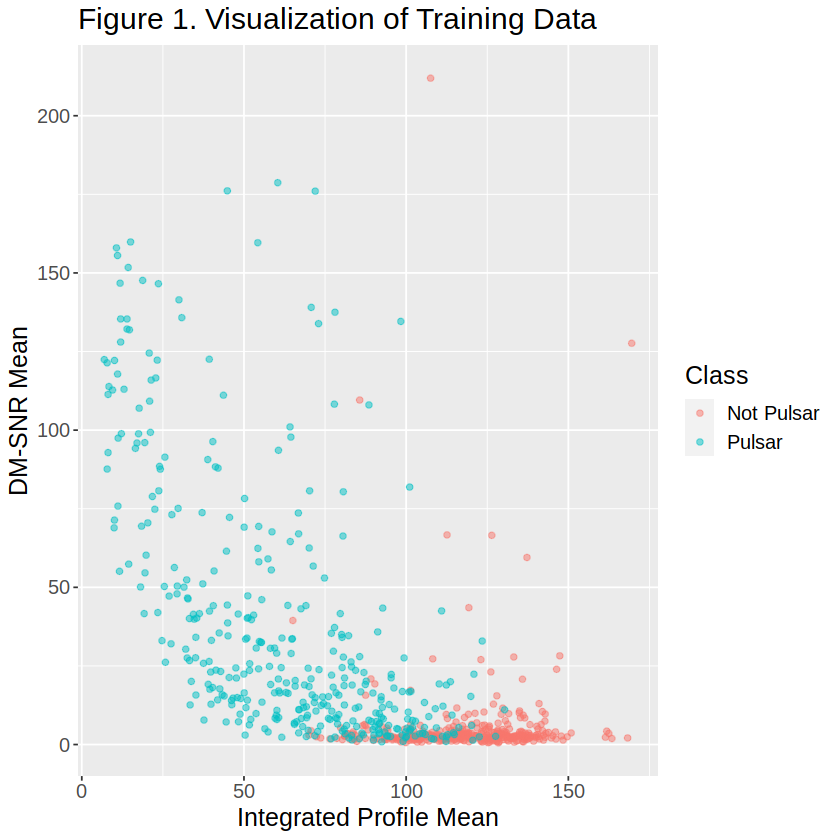

In [4]:
# 4 
# visualize data as part of preliminary data analysis
pulsar_plot <- ggplot(pulsar_train, aes(x = ip_mean, y = DM_mean, color = class)) +
    geom_point(alpha = 0.5) +
    labs (x = "Integrated Profile Mean", y = "DM-SNR Mean", color = "Class") + 
    theme(text = element_text(size = 15)) + 
    ggtitle("Figure 1. Visualization of Training Data")
pulsar_plot

> In this plot, the training data is shown against the predictive variables, where the class is distinguished by colour. The points do not appear to be completely randomly distributed, further supporting our choice of predictive variables. 


4. Next, we visualized the data using a plot. This visualization plotted the DM-SNR mean against the integrated profile mean, and coloured by class of the frequency. This plot allowed us to visually confirm that there is a possibility of our KNN classification being successful. Visually, the values do not seem to be completely randomly distributed across the range, there are some trends as far as the colouring. 

In [5]:
# 5
# KNN classification prep, determination of K
set.seed(1)
pulsar_recipe <- recipe(class ~ ip_mean + DM_mean, data = pulsar_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
pulsar_vfold <- vfold_cv(pulsar_train, v = 10, strata = class)
pulsar_fit <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(pulsar_spec) |>
    tune_grid(resamples = pulsar_vfold, grid = tibble(neighbors = c(2:40))) |>
    collect_metrics()
pulsar_accuracies <- pulsar_fit |>
    filter(.metric == 'accuracy')

5. KNN classification prep, determination of K
    + Create a recipe - scale and center all the predictors 
    + Create a model specification for K-nearest neighbours classification. We set it to “rectangular” so that each of the K-nearest neighbours gets 1 vote. Instead of picking a specific value for K, we tune it to determine the best K. Then we set the engine to “kknn”, and the model to “classification”.
    + Cross Validation - split the data into 10 groups to tune so that we can get the best K values based on the 10 groups instead of tuning only on 1 training set
    + Then we fit the recipe and the model to determine the accuracies of K-nearest neighbor. We also collect metrics on the accuracy for plotting and determination of K. 


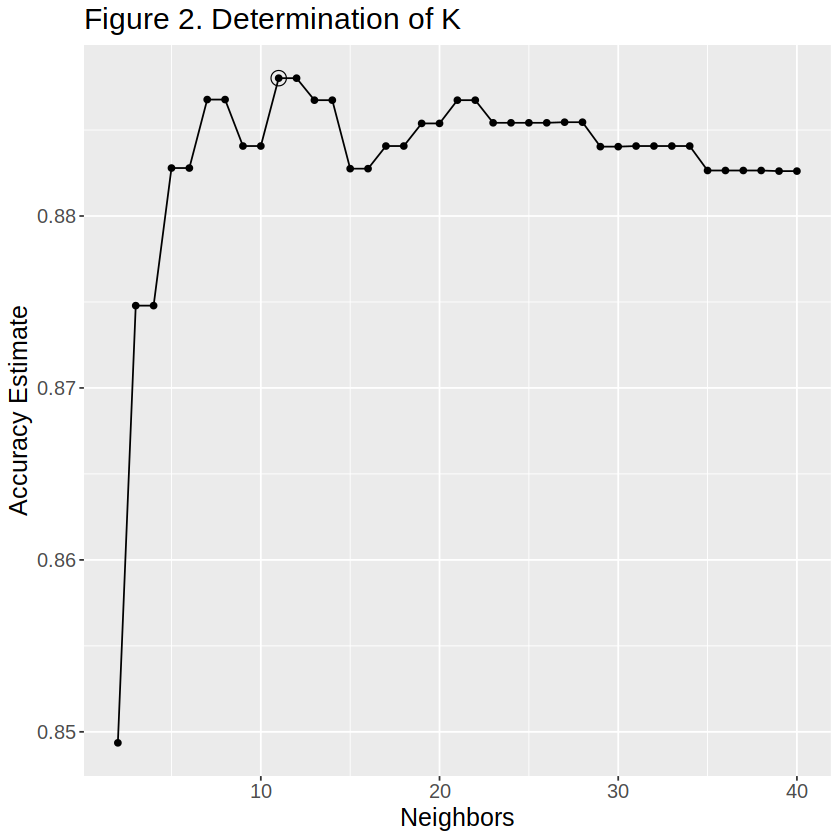

In [6]:
# 6
# determination of K via plot
pulsar_cross_valid <- ggplot(pulsar_accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = 'Neighbors', y = 'Accuracy Estimate') +
    theme(text = element_text(size = 15)) +
    ggtitle("Figure 2. Determination of K") + 
    geom_point(data=pulsar_accuracies |> filter(neighbors == 11), 
           pch=21, 
           size=4, 
           colour="black")
pulsar_cross_valid

> This visualization allows for the choice of K, through a comparison of an accuracy estimation and the number of neighbours, from 2 to 40. Interpreting the plot, a K of 11 was chosen (circled), as it provided the highest accuracy at the lowest K. 


6. Determination of K via plot
    + Using the accuracies determined in 5., a plot was generated to visually determine the best K. K = 11 was chosen (circled), as it had the highest accuracy, at the lowest possible K value. 


In [7]:
# 7
# train workflow with training data 
set.seed(1)
pulsar_recipe <- recipe(class ~ ip_mean + DM_mean, data = pulsar_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
    set_engine("kknn") |>
    set_mode("classification")
pulsar_fit <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(pulsar_spec) |>
    fit(data = pulsar_train)
pulsar_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1106667
Best kernel: rectangular
Best k: 11

7. Train workflow with training data
    + Repeat 5b but since we want to train the data with the best K, we change it to neighbor = 11 (the odd number that contains the highest estimates accuracy in the above plot)
    + Then we fit the recipe and the model to the training data

In [8]:
# 8
# predict with testing data 
set.seed(1)
pulsar_predictions <- predict(pulsar_fit, pulsar_test) |>
    bind_cols(pulsar_test)
pulsar_metrics <- pulsar_predictions |> metrics(truth = class, estimate = .pred_class)
pulsar_conf_mat <- pulsar_predictions |>
    conf_mat(truth = class, estimate = .pred_class) 
print("Table 2. Accuracy of Model Following Testing")
pulsar_metrics

[1] "Table 2. Accuracy of Model Following Testing"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9007937
kap,binary,0.8015873


> The accuracy and normalized accuracy (kap) of the model are shown after fitting the testing data. Both are quite high, suggesting a strong choice of predictive variables and neighbours. 


In [9]:
# 8 continued 
print("Table 3. Confusion Matrix")
pulsar_conf_mat

[1] "Table 3. Confusion Matrix"


            Truth
Prediction   Not Pulsar Pulsar
  Not Pulsar        115     14
  Pulsar             11    112

> This table is a confusion matrix for our model after classifying the testing data. A strong majority of points were classified correctly, and importantly the two classes appeared to have roughly equal misclassifications. 


In [10]:
# 8 continued 
print("Table 4. Precision and Recall")
precision <- 0.911 
recall <- 0.889 
precision_recall <- tibble(precision, recall)
precision_recall

[1] "Table 4. Precision and Recall"


precision,recall
<dbl>,<dbl>
0.911,0.889


> The precision and recall of the classification model were calculated, based on the confusion matrix from Table 3. These are both indicators of the strength of a classifier. 


8. Predict with testing data, generate confusion matrix  
    + Using the testing data following training, we used our model to predict the class of potential pulsar.
    + We then calculated the metrics for the accuracy, precision, and recall, as well as a confusion matrix. 


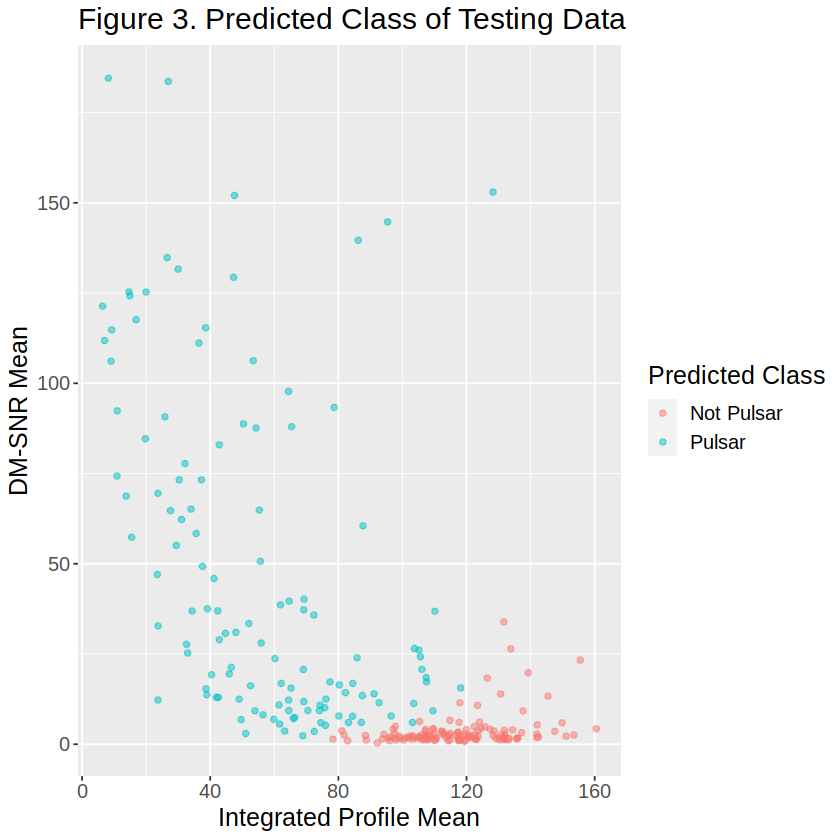

In [11]:
# 9 
# visualize results 
pulsar_visualize <- ggplot(pulsar_predictions, aes(x = ip_mean, y = DM_mean, color = .pred_class)) + 
    geom_point(alpha = 0.5) +
    labs (x = "Integrated Profile Mean", y = "DM-SNR Mean", color = "Predicted Class") + 
    theme(text = element_text(size = 15)) +
    ggtitle("Figure 3. Predicted Class of Testing Data")
pulsar_visualize

> Visualized are the predicted classes of the testing points, coloured by class. 


9. Visualize results 
    + Generate a plot showing the predicted class of potential pulsar, based on the predictions of our model. 


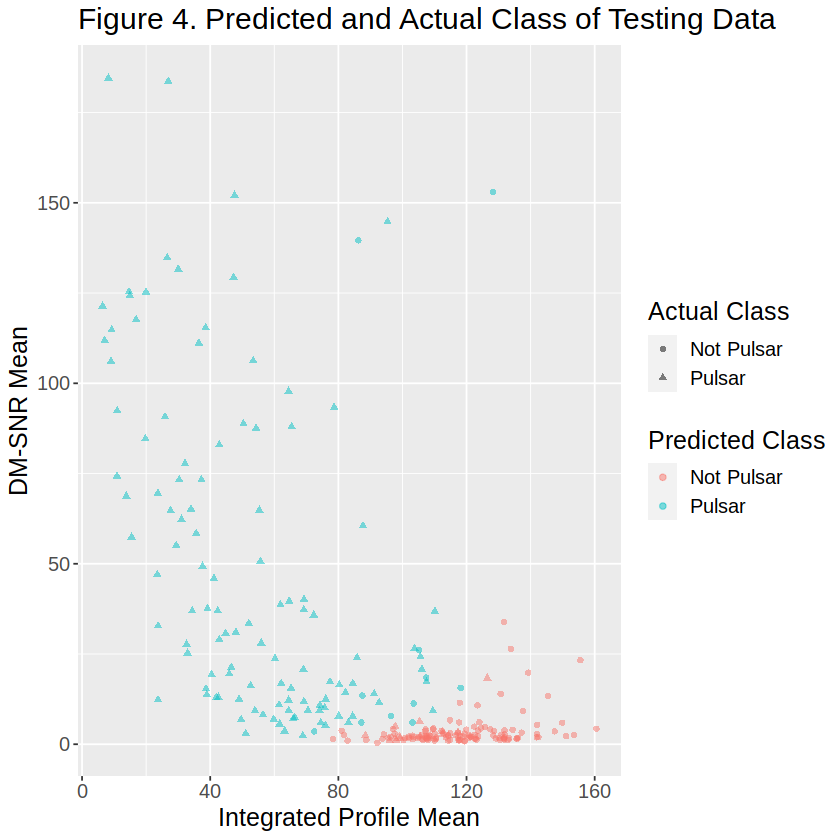

In [12]:
# 10 
# visualize confusion matrix
pulsar_confusion <- pulsar_predictions |>
    select(.pred_class) |>
    bind_cols(pulsar_test |> select(class, ip_mean, DM_mean)) |>
    as.data.frame()
pulsar_visualize_confusion <- ggplot(pulsar_confusion, aes(x = ip_mean, y = DM_mean, shape = class, color = .pred_class)) + 
    geom_point(alpha = 0.5) +
    labs (x = "Integrated Profile Mean", y = "DM-SNR Mean", color = "Predicted Class", shape = "Actual Class") + 
    theme(text = element_text(size = 15)) + 
    ggtitle("Figure 4. Predicted and Actual Class of Testing Data")
pulsar_visualize_confusion

> Similar to Figure 3, this plot visualizes the predicted class according to colour. Additionally, the confusion matrix is visualized through showing the actual class of the point by its shape. In this case, a blue triangle or red dot means that the classifier was successful. 

10. Visualize confusion matrix
     + Overlay the predicted class figure with the actual class, thereby visualizing the confusion matrix. 
    + In this case, a blue triangle or red circle indicates that the predicted class matches the actual class. 


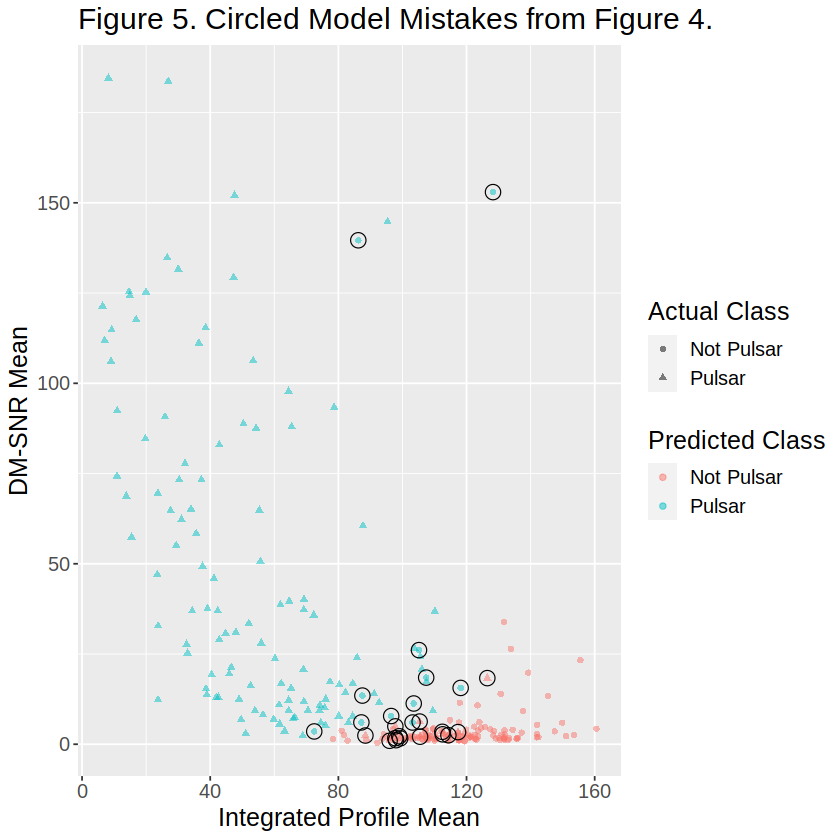

In [13]:
# 11 
# finding areas of weakness in the model 
pulsar_visualize_confusion_circled <- ggplot(pulsar_confusion, aes(x = ip_mean, y = DM_mean, shape = class, color = .pred_class)) + 
    geom_point(alpha = 0.5) +
    labs (x = "Integrated Profile Mean", y = "DM-SNR Mean", color = "Predicted Class", shape = "Actual Class") + 
    geom_point(data=pulsar_confusion |> filter(.pred_class != class), 
           pch=21, 
           size=4, 
           colour="black") + 
    theme(text = element_text(size = 15)) +
    ggtitle("Figure 5. Circled Model Mistakes from Figure 4.")
pulsar_visualize_confusion_circled

> Finally, points from Figures 3 and 4 are circled when the predicted does not match the actual class. This allows for a visual check on the accuracy of the classification, as well as identification of potential areas of weakness in the model. 


11. Finding areas of weakness in the model 
    + Finally, we circle any “mismatched” predictions versus truth points. This visually shows the accuracy of our model, and highlights potential areas of weakness. 


***

### DISCUSSION ###
**What we found**
* We found that our kknn model has a precision of 91.1% and recall of 88.9%. 
* Based on figure 3, we discover that the points for predicted pulsars are more scattered than the not pulsar. The predicted pulsars have greater DM-SNR mean versus Integrated Profile mean. Meanwhile, the non-pulsar points perform the opposite of the pulsar. There are more clusters and Integrated Profile Mean is greater than DM-SNR mean. 
* In figure 5, when we identify the points that were incorrectly classified, we see an interesting but unsurprising trend. The model had the most difficulty with misclassifying points near the “border” between the two groups. Again, considering this is a K nearest neighbours algorithm, this is not surprising.   

**Results compared to anticipated results**
* Generally, the classification worked better than expected. Considering there were numerous variables in the original data set, we anticipated having greater trouble accurately classifying the testing points. We would say that we were accurate in our choice of dependable predictive variables. 
* Largely, we believe that the success of the model is in large part due to the decision that the training and testing data were precisely 50/50 pulsar versus not pulsar, to ensure balance. This avoided issues with predominance of the non-pulsar points, as well as an inflation of our accuracy.   

**Potential impact**
* Such findings could be impactful in the quick selection of pulsar candidates for further research. While the model was not entirely accurate, it was largely correct. It is interesting to consider whether a simple screening of the mean of the integrated profile and DM-SNR curve could be used to immediately filter out most candidates.   

**Future questions**
* Can we set a threshold for the integrated profile and DM-SNR variables, to immediately filter out the majority of non-pulsar candidates?
* Similarly, can we narrow down the number of variables/measurements required in these predictions? 
* What is the accuracy of our model with the current number of neighbours if the data set were unbalanced? In reality there are far more pulsar candidates than pulsars, so it would be important to consider what would happen to the model in these cases. 

***

### REFERENCES ###
1. Lyon, R. J. (n.d.). HTRU2. UC Irvine Machine Learning Repository. https://doi.org/10.24432/C5DK6R
2. Lyon, R. J., Stappers, B. W., Cooper, S., Brooke, J. M., & Knowles, J. D. (2016). Fifty years of pulsar candidate selection: From simple filters to a new principled real-time classification approach. Monthly Notices of the Royal Astronomical Society, 459(1), 1104–1123. https://doi.org/10.1093/mnras/stw656
3. Lyon, R. J. (2016). Why are pulsars hard to find. https://api.semanticscholar.org/CorpusID:125875662
***